##Aluna: Andréa Fonseca

# Regressão Softmax com dados do MNIST

## Objetivo

O objetivo deste notebook é ilustrar o uso de praticamente a mesma rede desenvolvida para a classificação das flores Íris, porém agora com o problema de classificação de dígitos manuscritos utilizando o dataset MNIST.
As principais diferenças são:
- tipo do dado, agora imagem com muitos atributos: 28 x 28 pixels
- número de amostras, muito maior, 60 mil

Neste exercício será possível a interpretação do significado dos parâmetros treinados

## Importação das bibliotecas

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from torch.autograd import Variable
import torch
import torchvision

## Carregamento dos dados do MNIST

In [2]:
! git clone https://github.com/vcasadei/MNIST.git

Cloning into 'MNIST'...
remote: Enumerating objects: 10, done.
remote: Total 10 (delta 0), reused 0 (delta 0), pack-reused 10
Receiving objects: 100% (10/10), 11.01 MiB | 4.69 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (6/6), done.


In [3]:
dataset_dir = 'MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos apenas 1000 amostras de treinamento.

In [4]:
x_train = x_train.float()

x_train = x_train / 255.

if True:
    n_samples_train = 1000

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 1000

Dimensões dos dados das imagens:    torch.Size([1000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0.) tensor(1.)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Visualizando os dados

(-0.5, 232.5, 87.5, -0.5)

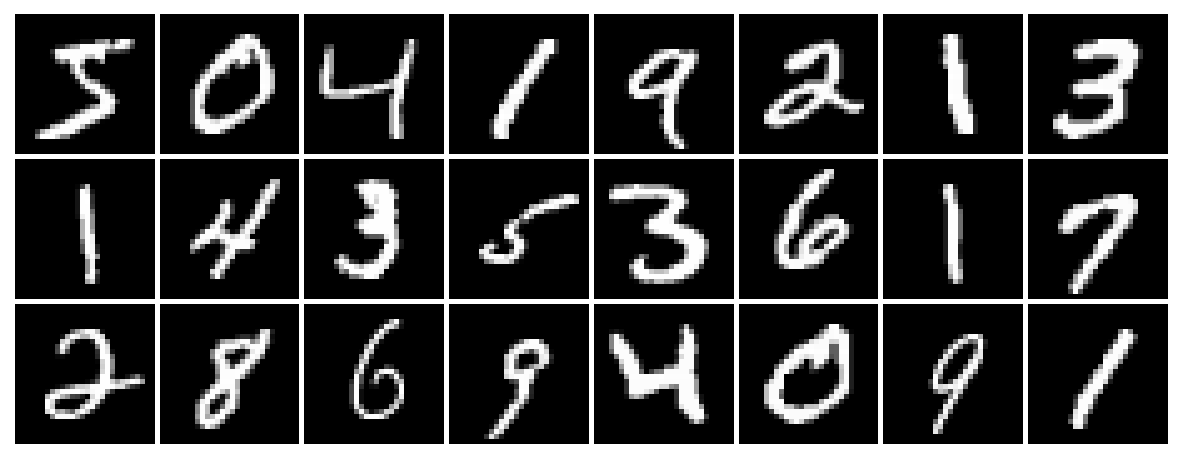

In [5]:
n_samples = 24

# cria um grid com as imagens
grid = torchvision.utils.make_grid(x_train[:n_samples].unsqueeze(1), pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')

### Visualizando uma imagem com o matplotlib

class: tensor(5)


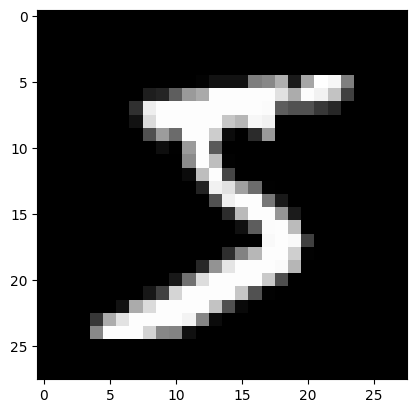

In [6]:
image  = x_train[0]
target = y_train[0]

plt.imshow(image.numpy().reshape(28,28), cmap='gray')
print('class:', target)

## Modelo

In [34]:
model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida

### Testando um predict com poucas amostras

In [17]:
## TODO
xin = x_train[:5].view(-1,28*28)
score = model(Variable(xin))
score

tensor([[-0.0762, -0.4488, -0.0293, -0.3095,  0.1867, -0.0311, -0.0050, -0.2022,
          0.0638,  0.0663],
        [-0.3355,  0.0264, -0.2082, -0.2076, -0.3643,  0.0098, -0.1219, -0.0841,
         -0.3694,  0.0322],
        [-0.1043, -0.0041, -0.1745, -0.1388, -0.0842, -0.0545,  0.0862, -0.0348,
         -0.2395, -0.0845],
        [-0.2184,  0.0963,  0.2728,  0.1199,  0.2418,  0.1546, -0.1115, -0.0314,
          0.1986,  0.2251],
        [-0.0183, -0.1279, -0.0987,  0.0267, -0.1488, -0.4496, -0.2423,  0.0314,
         -0.0421, -0.1782]], grad_fn=<AddmmBackward0>)

In [18]:
import torch.nn.functional as F
F.softmax(score, dim=1)*100

tensor([[ 9.8677,  6.7977, 10.3414,  7.8142, 12.8347, 10.3219, 10.5954,  8.6989,
         11.3501, 11.3780],
        [ 8.3142, 11.9401,  9.4434,  9.4489,  8.0785, 11.7431, 10.2945, 10.6906,
          8.0374, 12.0092],
        [ 9.7554, 10.7840,  9.0943,  9.4251,  9.9536, 10.2541, 11.8029, 10.4579,
          8.5222,  9.9506],
        [ 7.2266,  9.9000, 11.8108, 10.1358, 11.4507, 10.4939,  8.0425,  8.7131,
         10.9660, 11.2605],
        [11.0240,  9.8795, 10.1724, 11.5311,  9.6748,  7.1616,  8.8112, 11.5855,
         10.7650,  9.3950]], grad_fn=<MulBackward0>)

## Treinamento

### Inicialização dos parâmetros

In [35]:
epochs = 10
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Visualização do grafo computacional da perda (loss)

In [20]:
!pip install graphviz
!pip install git+https://github.com/szagoruyko/pytorchviz

  Cloning https://github.com/szagoruyko/pytorchviz to /tmp/pip-req-build-4tfbp68b
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz /tmp/pip-req-build-4tfbp68b
  Resolved https://github.com/szagoruyko/pytorchviz to commit 0adcd83af8aa7ab36d6afd139cabbd9df598edb7
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.10

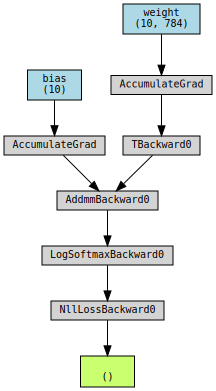

In [32]:
y_pred = model(Variable(x_train.view(-1,28*28)))
loss = criterion(y_pred, Variable(y_train))
from torchviz import make_dot, make_dot_from_trace
p = make_dot(loss, dict(model.named_parameters()))
p

### Laço de treinamento dos pesos

In [36]:
from IPython import display
import numpy

losses = []
zs = []
fig = plt.figure(figsize=(18, 6))

weights = model.state_dict()['weight']

try:
    for i in range(epochs):

        # Transforma a entrada para uma dimensão
        inputs = Variable(x_train.view(-1, 28 * 28))

        # Predict da rede
        outputs = model(inputs)
        zs.append(outputs[1].detach().numpy())

        # calcula a perda
        loss = criterion(outputs, Variable(y_train))

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.data)
        _, predicts = torch.max(outputs, 1)

        y_pred = predicts.data
        accuracy = (y_pred.numpy() == y_train.numpy()).mean()

except KeyboardInterrupt:
    pass

<Figure size 1800x600 with 0 Axes>

In [37]:
model.weight.grad

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [38]:
print('Final loss:', loss.data)

Final loss: tensor(0.7521)


### Visualizando gráfico de perda durante o treinamento

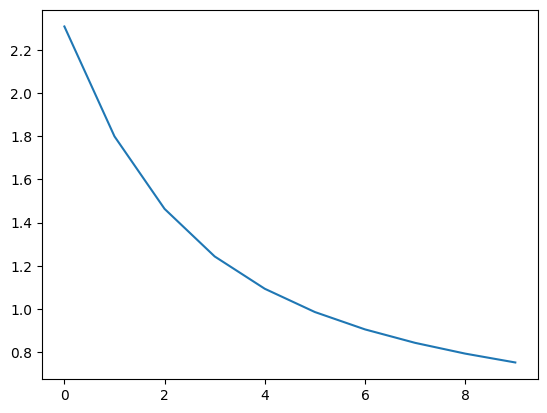

In [39]:
plt.plot(losses)

## Avaliação

### Acurácia tanto no conjunto de treinamento como no conjunto de testes

In [40]:
def predict(model, input_data):
    outputs = model(Variable(input_data))
    _, predicts = torch.max(outputs, 1)

    return predicts.data

y_pred = predict(model, x_train.view(-1, 28*28))
accuracy = (y_pred.numpy() == y_train.numpy()).mean()
print('Accuracy:', accuracy)

Accuracy: 0.858


### Matriz de confusão com dados de treinamento e teste

In [41]:
print('Matriz de confusão:')
pd.crosstab(y_pred.numpy(), y_train.numpy())

Matriz de confusão:


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,94,0,3,1,0,1,2,1,0,3
1,0,108,9,1,1,1,2,4,4,1
2,1,0,75,1,1,2,0,1,2,0
3,0,1,1,79,0,9,0,0,5,1
4,0,0,2,0,93,4,3,3,0,6
5,0,2,0,3,1,68,0,0,4,2
6,2,0,1,1,2,3,86,0,0,1
7,0,1,4,4,0,0,0,103,0,5
8,0,4,3,2,0,3,1,0,71,0


## Visualizando a matriz de pesos treinados

Observe que a matriz de peso treinado para cada classe mostra a importância dos pesos associados aos caracteres de cada classe.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


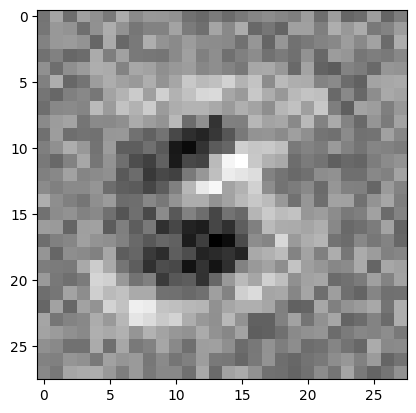

In [42]:
weights = model.state_dict()['weight']
print('weights:', weights.shape)

bias = model.state_dict()['bias']
print('bias:   ', bias.shape)

# Visualizando pesos da classe 3
plt.imshow(weights[3, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

### Visualizando os pesos de todas as classes

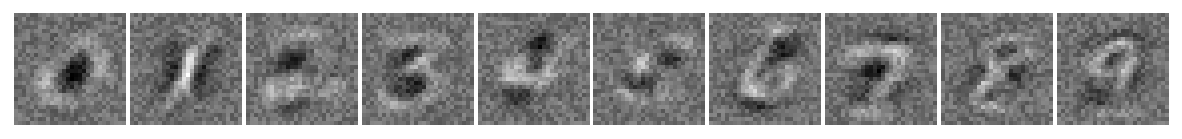

In [43]:
# cria um grid com as imagens
grid = torchvision.utils.make_grid(weights.view(-1, 1, 28, 28), normalize=True, pad_value=1.0, padding=1, nrow=10)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off');

### Diagrama da regressão softmax com visualização dos pesos W

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmaxArgmaxNMIST.png)

# Atividades

## Exercícios

- 1) Insira código no laço do treinamento para que no final de cada época,
     seja impresso: o número da época e a perda e a acurácia

In [44]:
model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida

epochs = 10
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

In [45]:
losses = []
zs = []
fig = plt.figure(figsize=(18, 6))

weights = model.state_dict()['weight']

try:
    for i in range(epochs):
        # Transforma a entrada para uma dimensão
        inputs = Variable(x_train.view(-1, 28 * 28))
        # Predict da rede
        outputs = model(inputs)
        zs.append(outputs[1].detach().numpy())

        # calcula a perda
        loss = criterion(outputs, Variable(y_train))

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.data)
        _, predicts = torch.max(outputs, 1)

        y_pred = predicts.data
        accuracy = (y_pred.numpy() == y_train.numpy()).mean()

        print(f'Época: {i}, Perda: {loss}, Acurácia: {accuracy}')

except KeyboardInterrupt:
    pass

Época: 0, Perda: 2.349438428878784, Acurácia: 0.072
Época: 1, Perda: 1.830665111541748, Acurácia: 0.649
Época: 2, Perda: 1.485097885131836, Acurácia: 0.744
Época: 3, Perda: 1.2593899965286255, Acurácia: 0.772
Época: 4, Perda: 1.106730341911316, Acurácia: 0.812
Época: 5, Perda: 0.9977598190307617, Acurácia: 0.814
Época: 6, Perda: 0.9163910746574402, Acurácia: 0.831
Época: 7, Perda: 0.853131115436554, Acurácia: 0.838
Época: 8, Perda: 0.8023654222488403, Acurácia: 0.846
Época: 9, Perda: 0.7605348825454712, Acurácia: 0.848


<Figure size 1800x600 with 0 Axes>

- 2) Insira código no laço do treinamento para visualização dos valores dos gradientes referentes à classe do dígito 4, no final de cada época.

In [51]:
model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida

epochs = 10
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)


Época: 0, Perda: 2.2709476947784424, Acurácia: 0.197, Peso_4: AxesImage(size=(28, 28))


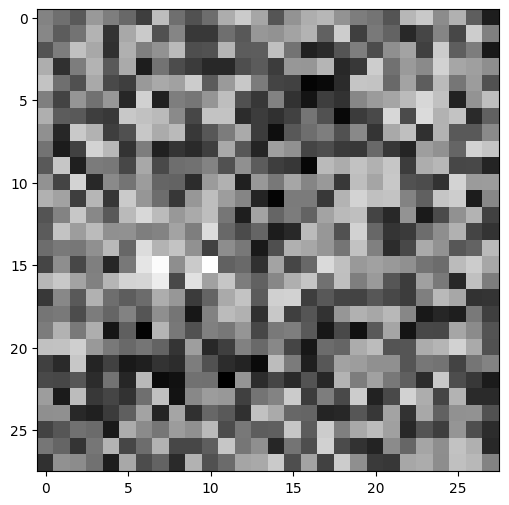


Época: 1, Perda: 1.7809404134750366, Acurácia: 0.697, Peso_4: AxesImage(size=(28, 28))


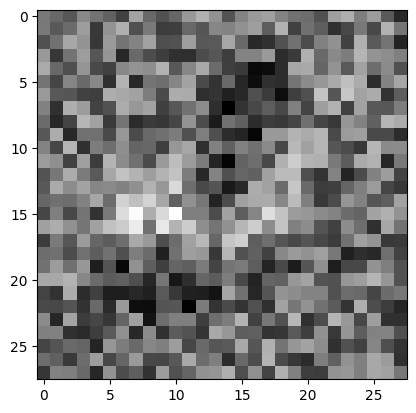


Época: 2, Perda: 1.4555473327636719, Acurácia: 0.72, Peso_4: AxesImage(size=(28, 28))


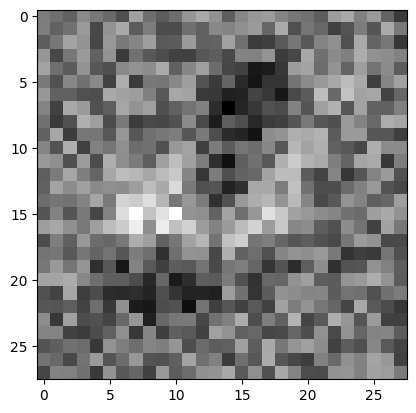


Época: 3, Perda: 1.2405673265457153, Acurácia: 0.786, Peso_4: AxesImage(size=(28, 28))


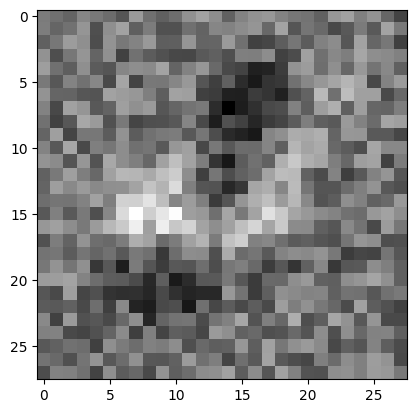


Época: 4, Perda: 1.0931787490844727, Acurácia: 0.805, Peso_4: AxesImage(size=(28, 28))


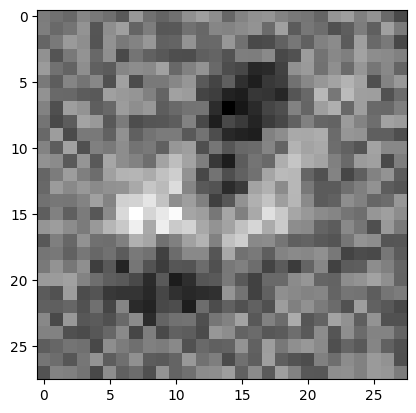


Época: 5, Perda: 0.9873843193054199, Acurácia: 0.824, Peso_4: AxesImage(size=(28, 28))


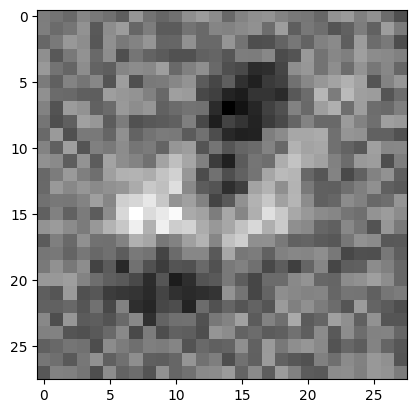


Época: 6, Perda: 0.907939612865448, Acurácia: 0.832, Peso_4: AxesImage(size=(28, 28))


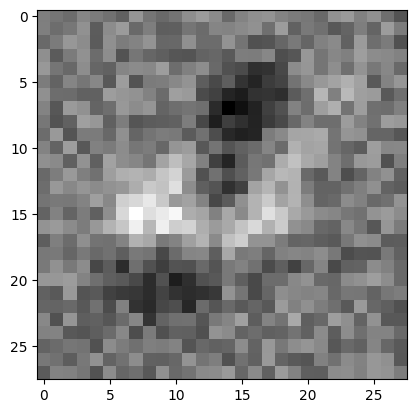


Época: 7, Perda: 0.8459919095039368, Acurácia: 0.839, Peso_4: AxesImage(size=(28, 28))


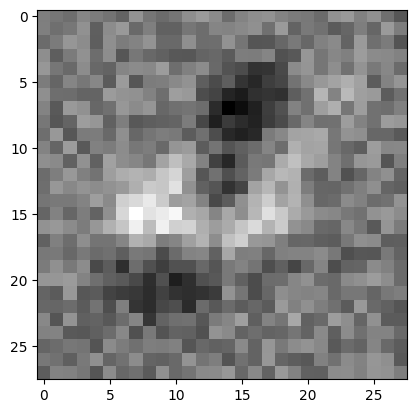


Época: 8, Perda: 0.7961680293083191, Acurácia: 0.843, Peso_4: AxesImage(size=(28, 28))


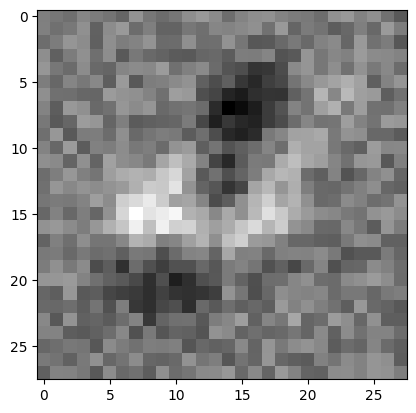


Época: 9, Perda: 0.755053699016571, Acurácia: 0.849, Peso_4: AxesImage(size=(28, 28))


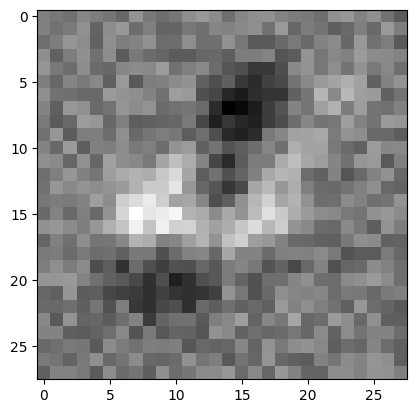

In [52]:
losses = []
zs = []
fig = plt.figure(figsize=(18, 6))

weights = model.state_dict()['weight']
pesos_4 = []

try:
    for i in range(epochs):
        # Transforma a entrada para uma dimensão
        inputs = Variable(x_train.view(-1, 28 * 28))
        # Predict da rede
        outputs = model(inputs)
        zs.append(outputs[1].detach().numpy())

        # calcula a perda
        loss = criterion(outputs, Variable(y_train))

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.data)
        _, predicts = torch.max(outputs, 1)

        y_pred = predicts.data
        accuracy = (y_pred.numpy() == y_train.numpy()).mean()

        pesos_4.append(weights[4, :])

        print(f'\nÉpoca: {i}, Perda: {loss}, Acurácia: {accuracy}, Peso_4: {plt.imshow(pesos_4[i].numpy().reshape((28,28)), cmap = "gray")}')
        plt.show()

except KeyboardInterrupt:
    pass

<details>
<summary>Mostrar Resultado</summary>

```python
from IPython import display
import numpy
a = 5
losses = []
zs = []
fig = plt.figure(figsize=(18, 6))

try:
    for i in range(epochs):
        # Transforma a entrada para uma dimensão
        inputs = Variable(x_train.view(-1, 28 * 28))
        # Predict da rede
        outputs = model(inputs)
        zs.append(outputs[1].detach().numpy())

        # calcula a perda
        loss = criterion(outputs, Variable(y_train))

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.data)
        weights_d = model.weight.data[4].numpy().reshape(28,28)
        weights_g = model.weight.grad.data[4].numpy().reshape(28,28)
        ww = np.concatenate((weights_d,weights_g),1)
        plt.imshow(ww.reshape((28,28*2)),cmap = 'gray')
        display.display(fig)
        display.clear_output(wait=True)
        input(i)
        
        _, predicts = torch.max(outputs, 1)

        y_pred = predicts.data
        accuracy = (y_pred.numpy() == y_train.numpy()).mean()
        print('Accuracy:', accuracy)
        print("epoca: " + str(i + 1))
        print("perda: " + str(loss.data.detach().numpy()))
except KeyboardInterrupt:
    pass
```

</details>



## Perguntas

1. Qual é o shape da matriz de entrada na rede?

(1000 x 784)

2. Qual é o shape da saída da rede?

(1000, 10)

3. Qual é o número total de parâmetros da rede, incluindo o bias?

784 pixels x 10 dígitos de entrada = 7840 + 10 bias = 7850 parâmetros na rede

# Aprendizados
